# Using TGNLP to Create Features for Model Training
## Author: Primrose Johns
Hello! In this guide, I will be demoing some of the useful features of a library I collaborate on (TGNLP).  Hopefully, this will help you to consider how TGNLP could be useful for your own projects.<br>
I will also be including information that will help someone proficient in Python but no with machine learning experience specifically. I hope you learn something new!<br>
I have formatted this guide into a list of steps, mostly because that's how I'm used to writing ML Jupyter Notebooks. Here's an overview of what I'll be covering:<br>
* Step 0: Loading in the dataset we want to train our classifier on.
* Step 1: Preprocessing the data before it goes into our graph generator (plus some pandas tips/tricks).
* Step 2: Turning our text data into a graph.
* Step 3: Turning our graph data into feature data (a matrix).
* Step 4: Dimensionality Reduction.
* Step 5: Model training and results.
* Step 6: Final results and Conclusion.

I hope you learn something new!

In [125]:
import TGNLP as tgnlp
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.dummy import DummyClassifier

from scipy.sparse import lil_matrix, csr_matrix

# Step 0: Load the Data
I will be using [this Kaggle dataset.](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset) The provided data is in two files, with each file containing the text of news articles. One file contains the text of fake news stories, and the other contains the text of real news stories. We will be creating a text classifier that can (hopefully) distinguish between the two. In this case we're downloading the kaggle-provided files manually, but it is possible to load the data from kaggle using an API call. Feel free to scroll down to the code block while reading this portion, to help you form a better idea of what's being described.

# Step 1: Preprocess the data
We're going to want to clean our data by removing any text entires that could negatively affect training. In our case, we will remove blank entries or entries that contain urls. We'll do this by making a function called `parse_data()`. This function takes a file path to a .csv file and a label as input, and will produce a pandas DataFrame object as output. If you're unfamiliar, a Pandas DataFrame is a kind of 2d storage object; its similar to a 2d array but it can change size like a linked list. It can also have columns and row names built in, rather than just having indexes.<br>
We will store the text of the articles in one column, and the label (true or false) in the other column. The provided dataset also has other information we won't use, so we remove that by overwriting the original data with a copy that only contains the "text" column. We do this using 
```
df = df[["text"]]
```
Even though our data is already seperated into true and false, we still need a labels column in our dataframe. This is because we're going to combine all the true and false articles together into one big database, and so we'll need to keep track of which is which.<br>
You can also see a line toward the bottom of `parse_data()` that reads:
```
df = df[df.apply(is_valid, axis=1)]
```
Let's break this line down. `df = df[...]` means that we are overwriting `df` with a version of itself that has had a mask applied. for example, if the DataFrame has three rows, and the mask you provide (where the ... is) is a list `[True, False, True]`, only the first and last rows will be kept. We are generating this true/false mask using `df.apply()`, which will go row-by-row (it would be column-by-column if `axis = 0`) and apply a provided function to its contents. If that function returns true when given a row as input, then that row's mask entry will be true (and it will be kept in the database). In our case, the function provided is called `is_valid()`. This function extracts the "text" column (which contains a string) in the row provided and checks if that string contains a url, is empty, or is a single space. So, in practice, this one line of code overwrites the DataFrame `df` with a new version that has had some rows removed. The removed rows were any that contained text entries that failed the `is_valid()` check.

In [93]:
#This function removes entries that are urls, empty, or a single space
def is_valid(row):
  s = row["text"]
  if re.search("https", s) is None and s != "" and s != " ":
    return True
  else:
    return False

#This loads the csv data and uses is_valid to trim bogus entries
def parse_data(path, label):
  df = pd.read_csv(path)
  df = df[["text"]]
  df = df[df.apply(is_valid, axis=1)]
  df["label"] = label
  return df

Now that we have our functions defined, we can use them to create our preprocessed dataset. We will also combine the fake and true datasets together, which we will shuffle and split in the next step.

In [157]:
#Here we use the previous functions to load the data
fake_df = parse_data("Fake.csv", 0)
real_df = parse_data("True.csv", 1)
#Now we'll concatenate our data together
raw_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
#This will show us the first 5 entries
print(raw_df.shape)
raw_df[:5]

(40971, 2)


,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,Pope Francis used his annual Christmas Day mes...,0
3,The number of cases of cops brutalizing and ki...,0
4,Donald Trump spent a good portion of his day a...,0


Here we can see the first few entries our new dataset! Its been formatted into two columns and trimmed down to 40,971 rows. The original dataset had 44,919 samples, so we can see that around 4,000 articles have been removed. We can also see that all of the first five samples are in the "false" category, and this is no coincidence. We still need to shuffle the data, and partition it into a training set and a testing set. Conveniently, the sci-kit learn library has a function `train_test_split()` that will shuffle and split our data for us.<br><br>
Side note:<br>This split is a fundamentally important part of machine learning. We need to ensure that the model we create will make accurate predictions on new data, and so not using some of our data for training is neccessary to simulate that "newness" when we move on from training to testing.

In [95]:
train_raw, test_raw = train_test_split(raw_df, test_size = .1, random_state = 42)
#train_raw = train_raw[:1000]
train_raw.reset_index(drop=True, inplace=True)
train_raw[:5]

,text,label
0,WASHINGTON (Reuters) - Oklahoma Attorney Gener...,1
1,WASHINGTON (Reuters) - President Donald Trump ...,1
2,Not that the word legal means anything to ei...,0
3,Donald Trump s proposal to build a wall betwee...,0
4,Donald Trump has made it a point of his campai...,0


# Step 2: Turning the data into a sequential graph with TGNLP
Finally, we are ready to start making graphs!<br>
For this portion, we will use the [TGNLP library](https://pypi.org/project/TGNLP/). This library will allow us to make a simple graph from the text data we've collected. First, we will feed the "text" column of our Pandas DataFrame to the constructor for a `TGNLP.Corpus` object. Then, we will use that as the input to a graph generator. This will output a NetworkX graph, which is a library with some great tools for working with graphs. We will use the sequential graph for this problem, where words are nodes and edges represent how often two words are close to one another. We will also trim the graph, removing edges that are very small.

In [96]:
#Create the corpus
corpus = tgnlp.Corpus(train_raw["text"])
#Create sequential
seq = tgnlp.get_sequential_graph(corpus)
seq = tgnlp.trim_norm_graph(seq)

In [97]:
print(seq.number_of_nodes())
print(seq.number_of_edges())

134451
1514726


It's as easy as that! Our trimmed graph has 134,451 nodes (one for each word) and 1.5 million connections between those words. These edges are weighted, but we won't use that info for this approach.
# Step 3: Turning our Graph Data Into Feature Data 
Now that TGNLP has processed our text data into graph data, we just need to turn that graph data into features that can be represented as a matrix so that we can use it for training.<br>
To do this, there are many options we could pursue. We will just be focusing on options where each word is a feature, so the matrix has a width the size of the total wordcount and the height is the number of training samples. If a word is not present in a particular sample, its value will be 0 (similar to one-hot encoding). If the word is present in the sample, we will represent it with some metric. This configuration will create a 134,451 by 40,971 matrix, which is quite large. We will be using a sparse matrix to save space, which I will go into more detail about later in this guide.<br>
In this configuration, there are several candidates for what metric we could use. We could store the cetrality of each node in the sample, with NetworkX offering a total of 43 centrality measure to choose from. We could use a clustering algorithm, and represent each word in a sample with its community. However, this would require one-hot encoding to be done correctly, which would increase the size of our training matrix dramatically.<br>
We will instead use an even simpler metric than the ones we've just dicussed, which we'll call subgraph degree. Each present word in a sample will simply be represented by the number of connections that it has to other words in the same sample (an induced sugraph). Let's write the code to create our subgraph degree feature data.<br><br>
Note: We are switching from a DataFrame to a matrix here, even though in theory we could continue using a DataFrame. This is because the resulting dataset is going to be downright huge, and matrices can be customized to be highly space efficient.

## 3a: Creating the column dictionary
Matrices, unlike DataFrames, do not have column labels. So, we'll need our own way to keep track of which column correlates to which word. We will do this using a simple dictionary, where we can use each word as a key to lookup its column. Since each node in the networkx graph is a word, we will just iterate through the nodes to account for every word.

In [98]:
#this dictionary will help us keep track of which column maps to which word
def column_dict(G):
  count = 0
  cref = {}
  for node in G.nodes:
    cref[node] = count
    count +=1
  return cref

## 3b: Create our Feature Matrix
First, will use the function that we just made above to create our column lookup dict. The purpose of this was discussed in the section above.<br>
Next we will declare our sparse matrix, which are more space effecient when most of the values in the matrix are 0. We can assume this will be the case, since even very long news articles are unlikely to have even half of the 134k total unique words. Even while sparse, this matrix will be very large, so we'll be using unsigned short ints instead of regular ints. If this were a dense matrix, even using short ints the resulting object would be more than 11gb in size!<br>
The big loop is the last part of our function. We go row by row in our training data, and grab a list of all the unique words in each sample. Since we already have tgnlp imported, we can just use one of their internal functions to get a list of words without whitespace, numbers, of punctuation. Then, we can cast the list as a set, which removes duplicates, and finally cast it back to being a list to get our list of unique words.<br>
We also want to work with a subgraph of only the words in this sample. By doing this, each node's degree represents a word's connections with other words in that sample. If we used the full graph, which is more efficient, node degree would be representing connections accross all the samples in or training data.<br>
Finally, we go through every word in the sample. If a word isn't in our subgraph (see note), we ignore it. If it is in the subgraph, we find its degree and record that in our matrix.<br>
Finally, we return our new sparse matrix! Now we just need to call this function, and we should be ready to move on to model training.<br><br>
Note: The reason why we check if the word we're looking at is in the subgraph is to account for new samples outside our training data that have new unique words. Since those words don't be nodes in the graph we made with our training data, they won't have a column assigned for them in the matrix and will need to be skipped.

In [99]:
#data is the traing dataframe, G is the big graph, and cref is the column lookup
def pop_sparse(data, G):
  cref = column_dict(G)
  #print("function start")
  #np.ushort is 2-byte unsigned int
  sparse = lil_matrix((data.shape[0], G.number_of_nodes()), dtype=np.ushort)

  #print("matrix and labels objects created")
  #for each row in the dataframe
  for index, row in data.iterrows():
    word_list = list(set(tgnlp.data_to_corpus(row["text"], corpus_type='word')))
    g = nx.induced_subgraph(G, word_list)
    for node in word_list:
      if g.has_node(node) == False:
        continue
      #print(node)
      degree = g.degree(node)
      #print(degree)
      column = cref[node]
      #print(index, column, sep=" ")
      sparse[index, column] = degree
      #print("sparse assgn")
  return sparse

In [17]:
train_mat = pop_sparse(train_raw, seq)

All done!<br>
This took my machine several hours to complete, however I did it sequentially on a $250 home server. Since I suspect anyone who tries this will be operating under similar constraints, you should consider pickling your output. pickle is a built-in python library that can turn any object into a file, so if you perform a big experiment like this and get a big output (like a massive matrix) you can save it for later without worrying about it being deleted from memory when your runtime ends.

In [19]:
#this code stores out big matrix as a file, so that it can be saved even when the current runtime ends
output = open('sparse.pkl', 'wb')
pickle.dump(train_mat, output)
output.close()

Alright, now to load the data back in from the file. I need to do this, since I actually did restart the runtime of my notebook here. I'll also convert our lil_matrix to a csr_matrix, since that's what our ML library expects as input

In [23]:
#This code loads the big matrix
file = open('sparse.pkl', 'rb')
exp_mat = pickle.load(file).tocsr()
file.close()

Now our matrix is loaded in, and ready for us to use!
# Step 4: Dimensionality reduction
As I've mentioned before, this approach creates a **lot** of data for us to use. This will dramatically increase the time to train a model. To help alleviate this issue, we will use dimensionality reduction. Dimensionality reduction is, to put it simply, a way to turn big datasets into smaller datasets that are almost as useful as the big datasets. Common uses of dimensionality reduction include faster model training (because the dataset is smaller) and visualization (to make the data fit neatly into a 2D grid). We will be doing both here.
## 4a: Data Visualition using TSNE
TSNE is a type of reduction normally used to convert large, complex data into 2D or 3D data so that it can be plotted. Its very simple to use, so lets use it to get a look at our data. We're also only going to use 1000 samples here for the plot itself, since there's really no way to make a 40k-point scatter plot look good.

In [27]:
#I'm literally copying this part directly from the sklearn documentation lol
data_vis = TSNE(n_components=2, learning_rate='auto',

                  init='random', perplexity=3, n_jobs = -1).fit_transform(exp_mat)

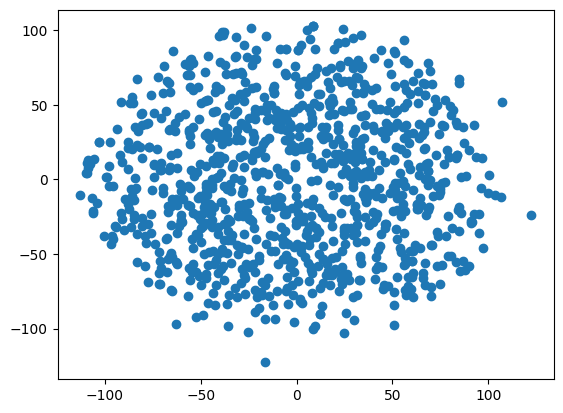

In [159]:
plt.scatter(data_vis[:1000, 0], data_vis[:1000, 1])
plt.savefig("clustering-fake-real-no-color.png")
plt.show()

Well that sure is a big, useless blob!<br>
What we need to do to make this readable is to change the color of the dots to distinguish between fake and real news stories.

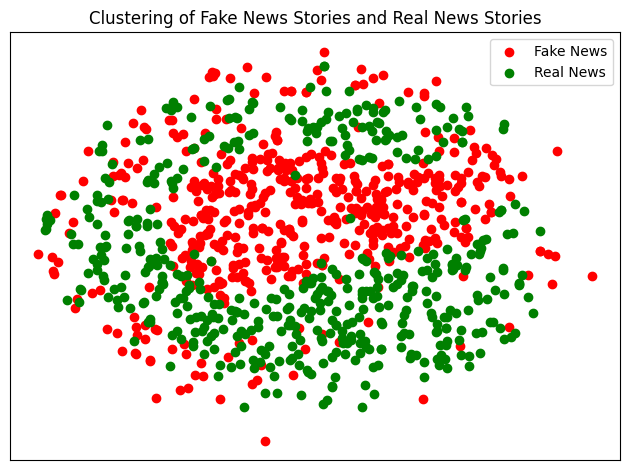

In [158]:
#make a new dataset for this vis
vis = pd.DataFrame(data_vis)
vis = pd.concat([vis, train_raw["label"]], axis=1, ignore_index=True, sort=False)
vis.columns = ["x", "y", "label"]
#plot the false set
plt.scatter(data=vis[vis["label"] == 0][:500], x = "x", y = "y", color="red")
#plot the true set
plt.scatter(data=vis[vis["label"] == 1][:500],  x = "x", y = "y", color="green")

#formatting/title setting
plt.title("Clustering of Fake News Stories and Real News Stories")
plt.legend(["Fake News", "Real News"])
plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False) 
plt.tight_layout()
plt.savefig("clustering-fake-real.png")
plt.show()

This tells us much more information! Notably, there appears to be strong clustering of both fake and real news stories, at least based on the first 500 samples of each type of article. With a trend this clear with just 2 features, it seems reasonable to assume that dimensionality reduction should be able to simplify our data accurately for model training as well!

## 4b: Dimensionality Reduction Using PCA
To get a simplified dataset for model training instead of visualization, we're going to use PCA. PCA is a common choice for this kind of task, it can take a sparse matrix as input, and it has the convient ability to reduce the data as a function of variance instead of the number of components. That means that we can tell PCA that we want the simplest dataset it can make while still being x% accurate to the original data. Unfortunately, this feature isn't availible when reducing sparse data, so we'll have to run it with a few different n_components values and see what kind of explained variance we can get. We probably don't want to go above 500 features, and preferably we should stay below 200. Lets try out a range between those two values.<br>

In [81]:
for i in [250, 300, 350, 400, 450, 500]:
    pca = PCA(n_components = i, random_state = 42)
    train_reduced = pca.fit_transform(exp_mat)
    print(f"Number of Components: {i}\nTotal exlained variance: {sum(pca.explained_variance_ratio_)}")

Number of Components: 250
Total exlained variance: 0.9044953127159896
Number of Components: 300
Total exlained variance: 0.908461295499216
Number of Components: 350
Total exlained variance: 0.9119255542088498
Number of Components: 400
Total exlained variance: 0.9150269445064977
Number of Components: 450
Total exlained variance: 0.9178444522792206
Number of Components: 500
Total exlained variance: 0.9204230040893924


Here, we can see that we seem to be getting diminishing returns on very large datasets. Still, 90% is quite good. Let's try a range of smaller numbers of components and see how those perform.

In [82]:
for i in [20, 50, 100, 150, 200]:
    pca = PCA(n_components = i, random_state = 42)
    train_reduced = pca.fit_transform(exp_mat)
    print(f"Number of Components: {i}\nTotal exlained variance: {sum(pca.explained_variance_ratio_)}")

Number of Components: 20
Total exlained variance: 0.8652734611898522
Number of Components: 50
Total exlained variance: 0.8773158694484345
Number of Components: 100
Total exlained variance: 0.8874180315983584
Number of Components: 150
Total exlained variance: 0.8943674480185655
Number of Components: 200
Total exlained variance: 0.8998787599772679


Wow, the difference between 20 features and 250 features is an explained variance of only ~4%! Let's work with the 20-feature dataset for now, and see how well our model performs.<br><br>
Note: PCA outputs a dense numpy array, not a sparse matrix. However, Since the data is so much smaller, that will work fine.

In [83]:
pca_20 = PCA(n_components = 20, random_state = 42)
train_reduced = pca_20.fit_transform(exp_mat)

# Step 5: Model Training
We've made our feature data from our initial input, and we've reduced it down to a very managable size. Now, let's train some models on our data. We will be training two models, a random forest and an SVC. An explanation of what these models are and how they work is outside of the scope of this guide, but if you're interested in the subject I highly reccomend "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron

## 5a: Using a Random Forrest to detect fake news stories
Here we're going to use sci-kit learn's cross_val_score() function, which will tell us how accurate out of 100% our model is when its trained on different portions of the training data.

In [91]:
rfc = RandomForestClassifier(max_depth = 10, n_jobs = -1, random_state = 42)
scores = cross_val_score(rfc, train_reduced, train_raw["label"], cv=5)
scores

array([0.95254237, 0.95484746, 0.95254237, 0.95077299, 0.95023054])

95% accurate! These are promising results<br>
Now let's train the model on the the entire training dataset, and then test it against the testing dataset! We'll need to peform the same data transformations on our test data that we did on our training data for this, so that its also in a reduced 20-feature format.

In [104]:
#Create a matrix out of our test data (using the graph we made with the train data)
test_raw.reset_index(drop=True, inplace=True)
test_mat = pop_sparse(test_raw, seq)

In [108]:
#Reduce our dataset using the pca object we fit to the training data 
test_reduced = pca_20.transform(test_mat)

In [110]:
#train the model on the training data
rfc.fit(train_reduced, train_raw["label"])
#predict labels for our test data
test_pred = rfc.predict(test_reduced)
print(classification_report(test_raw["label"], test_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.95      1962
           1       0.94      0.98      0.96      2136

    accuracy                           0.96      4098
   macro avg       0.96      0.96      0.96      4098
weighted avg       0.96      0.96      0.96      4098



96% accurate, and thanks to our dimensionality reduction it runs fast as well! The slowest part is populating the sparse matrix, but even that takes no more than a few seconds for a single article. Now let's try another model, an SVC.

## 5b: Using an SVC to predict fake news stories
SVC's can be a little more complex to configure than a random forrest, so for this we'll use GridSearchCV. GridSearchCV allows us to automate the process of testing the accuracy of different configurations of a provided model, in this case an SVC. Let's try out some combinations and see which one performs best.

In [119]:
svc = SVC(kernel = "poly", random_state = 42)
params = {'C':[1, 5, 10, 15], "degree": [1, 3, 6]}
gs = GridSearchCV(svc, params, n_jobs=-1)
gs.fit(train_reduced, train_raw["label"])

GridSearchCV(estimator=SVC(kernel='poly', random_state=42), n_jobs=-1,
             param_grid={'C': [1, 5, 10, 15], 'degree': [1, 3, 6]})

In [120]:
print(gs.best_score_)
print(gs.best_params_)

0.9493394969958582
{'C': 15, 'degree': 1}


These are the results of the best model tested, and its results are also pretty good. let's see so how the model performs when its trained on the entire training database.

In [124]:
#train the model
svc = SVC(kernel = "poly", random_state = 42, C = 15, degree = 1)
svc.fit(train_reduced, train_raw["label"])
#predict labels for our test data
test_pred = svc.predict(test_reduced)
print(classification_report(test_raw["label"], test_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1962
           1       0.95      0.95      0.95      2136

    accuracy                           0.95      4098
   macro avg       0.95      0.95      0.95      4098
weighted avg       0.95      0.95      0.95      4098



Just a hair less impressive than our random forest model, but still very good. Our 20-feature dataset produced a model that is right 19 times out of 20, and the model itself is a simple 1-dimensional SVM.<br>
## 5c:  Using a dummy classifier to predict fake news stories
Let's quickly perform a control test using a dummy classifier, just to make sure the data isn't skewed in some way. A dummy classifier is a model that always predicts the most common label in its training data. This mimics a particularly bad model, and is very useful for making sure that your data doesn't overly favor one label. A model that's 95% accurate isn't very good if it turns out that 90% of the data is all the same class.

In [126]:
dc = DummyClassifier()
dc.fit(train_reduced, train_raw["label"])
test_pred = dc.predict(test_reduced)
print(classification_report(test_raw["label"], test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1962
           1       0.52      1.00      0.69      2136

    accuracy                           0.52      4098
   macro avg       0.26      0.50      0.34      4098
weighted avg       0.27      0.52      0.36      4098



/home/userp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/userp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/userp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Since our training data (and our data as a whole) has slightly more true articles than fake articles, the classifier simply guessed true (1) for every article. This gives us an overall accuracy of 52%, which suggests that our real models (and the data they were trained on) is actually performing well!
# Step 6: Visualization and Conclusion
Overall, I hope this was able to demonstrate the potential of using a graph representation of text for classification. Even by using a simple metric (degree) from a simple graph type (sequential), it produced features powerful enough to train even a simple model to classify text quickly and accurately. In a real-world scenario, I would reccommend generating and saving the graph, the training data matrix, and the PCA model. If you were to hook this up to a webpage you would only need the graph and the PCA model. However, since the training data matrix takes a long time to generate and is relatively small (ours was 137mb) its worth saving if you want to tweak your dimensionality reduction method.<br>
Thank you for reading, and I hope you learned something!

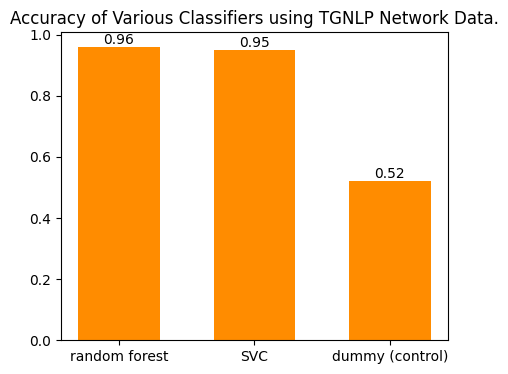

In [156]:
results = {"random forest": .96, "SVC": .95, "dummy (control)": .52}
plt.figure(figsize=(5, 4))
plt.bar(results.keys(), results.values(), color = "darkorange", width = .6)
plt.title("Accuracy of Various Classifiers using TGNLP Network Data.")
# This portion is off SO
rects = plt.gca().patches
for rect, label in zip(rects, results.values()):
    height = rect.get_height()
    plt.gca().text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
    )
plt.savefig("final-results-vis.png")
plt.show()